# (Supplementary) Capstone Project Part 1: Data Preprocessing

**Author:** Soohyun Ahn <br>
    
**Date:** April 2023

**Notebook Number:** 1/ 4 (in the **Supplementary** folder)

**IMPORTANT NOTE**: 
This notebook is an alternative to the main notebook, [Part_1_Data_Cleaning_Preprocessing](https://github.com/treelunar/2023_Capstone_BSTN/blob/main/Part_1_Data_Cleaning_Preprocessing.ipynb). During the initial stages of my project, I worked with two datasets simultaneously with the intention of selecting one based on their respective performances. However, once I had finalized my project, I decided to showcase it using the chosen dataset, as having multiple notebooks in parallel could potentially overwhelm readers and detract from the overall workflow. As a result, I created a separate folder for the notebooks related to the dataset that was not chosen.

Natural Language Processing (NLP) allows computers to process language in a manner similar to humans. To achieve this, raw text data must be converted into a clean, structured format that computers can understand. Text preprocessing involves several steps, including removing inconsistencies, noise, and irrelevant information, which enhances the efficiency and accuracy of NLP models. High-quality preprocessing enables computers to better comprehend the underlying patterns and relationships within the text.

In this notebook, I will clean our dataset, conduct Exploratory Data Analysis (EDA), and preprocess the text to prepare it for feature engineering and modeling. I will use a dataset called ["MPST: A Corpus of Movie Plot Synopses with Tags"](https://ritual.uh.edu/mpst-2018/#download). It was created by a group of researchers ([Sudipta Kar](http://sudiptakar.info/) and Suraj Maharjan and A. Pastor López-Monroy and Thamar Solorio), and the research paper can be accessed [here](https://aclanthology.org/L18-1274/). They used the dataset to automatically generate tags for movies.

I am using the dataset for a different purpose: **creating a movie recommendation system using NLP and unsupervised ML techniques, driven by user-input storylines for a more personalized experience**.

## Dataset Inspection

In [89]:
# Import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random

# Set the random seed

random.seed(42)
np.random.seed(42)

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [91]:
# Import dataset

mpst_df = pd.read_csv('mpst_full_data.csv', sep=',')
mpst_df.head()           

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb


In [6]:
# Take a lookt at the dataframe
mpst_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14828 entries, 0 to 14827
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   imdb_id          14828 non-null  object
 1   title            14828 non-null  object
 2   plot_synopsis    14828 non-null  object
 3   tags             14828 non-null  object
 4   split            14828 non-null  object
 5   synopsis_source  14828 non-null  object
dtypes: object(6)
memory usage: 695.2+ KB


In [109]:
# Check the null values
mpst_df.isna().sum()

imdb_id            0
title              0
plot_synopsis      0
tags               0
split              0
synopsis_source    0
dtype: int64

In [108]:
# Take a lookt at random rows
mpst_df.sample(10)

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
6244,tt0025536,Music in the Air,The musical takes place in Bavaria during the ...,romantic,val,wikipedia
8595,tt0274944,Teen Devian,Teen Deviaan starts off to commentary by Ameen...,romantic,train,wikipedia
14101,tt0081696,Urban Cowboy,Bud Davis (John Travolta) moves to Houston for...,violence,val,wikipedia
13228,tt1455811,Khatta Meetha,The film revolves around a struggling road con...,satire,val,wikipedia
8024,tt0120667,Fantastic Four,Physicist Reed Richards is convinced evolution...,"entertaining, action, murder, boring, fantasy",train,wikipedia
7691,tt1830522,Bulletstorm,"Bulletstorm takes place in the 26th century, w...","revenge, comedy, violence, flashback",train,wikipedia
7194,tt0339579,Ritânâ,"Milly (Anne Suzuki) is a soldier from 2084, wh...","neo noir, murder, cult, violence, flashback, a...",train,wikipedia
9472,tt0064638,Marlowe,Los Angeles private eye Philip Marlowe is hire...,"neo noir, murder",val,wikipedia
8381,tt0014826,Dante's Inferno,The exhumation of Lizzie Siddal's desiccated b...,"allegory, psychedelic",test,wikipedia
12246,tt0101765,La double vie de Veronique,"In Poland in 1968, a little girl is shown the ...","psychedelic, mystery, depressing",train,wikipedia


Certain movie titles in our dataset are in non-English languages. While this is not inherently problematic, it may pose challenges during the final stages of building a movie recommendation app where films are suggested to users.

## Web Scraping

To ensure quick retrieval and convenience, we will obtain English titles for these movies, if available. By utilizing the IMDb IDs, we can effectively scrape English titles from the IMDb website for seamless integration into our recommendation app.

In [8]:
import re

# Create a regular expression to match non-printable characters
non_printable = re.compile(r'[^\x20-\x7E]')

# Filter the dataframe to find rows with non-printable characters in the title column
rows_with_non_printable = mpst_df[mpst_df['title'].str.contains(non_printable)]

# Select only the 'title' and 'imdb_id' columns of the filtered dataframe
titles_and_ids = rows_with_non_printable.loc[:, ['title', 'imdb_id']]

pd.set_option('display.max_rows', None)

# print titles and imdb_ids of rows with non-printable characters
print(titles_and_ids)
print(f"There are {len(titles_and_ids)} movies with non-English titles.")

                                                   title    imdb_id
115                                           Antikörper  tt0337573
131             Kozure Ôkami: Sanzu no kawa no ubaguruma  tt0068816
145                                   Die Säge des Todes  tt0083156
165                                          Gölgesizler  tt1437212
196                          K-20: Kaijin nijû mensô den  tt1156395
200                                 Valerie a týden divu  tt0066516
214                                    Såsom i en spegel  tt0055499
248                Sentô shôjo: Chi no tekkamen densetsu  tt1590796
280                                       Kôkaku Kidôtai  tt0113568
313         ¡Que Viva Mexico! - Da zdravstvuyet Meksika!  tt0079020
342                                          Kozí príbeh  tt1308650
344                                    Les lèvres rouges  tt0067690
437                                            El método  tt0427582
498                                             

There are total 439 movies with non-English titles. This is not problematic in itself. But retrieving non-English movie titles can potentially create problems so we will add a new column that contains English titles.We can scrape English titles from IMDb website using `imdb_id`. 

We will insert the code that gives the random interval between 2 to 8 seconds for each request to prevent overwhelming the server. It is known that some websites may block or restrict access to certain user agents. In order to avoid this problem, it's common practice to set a user agent header to mimic a popular web browser, such as Mozilla Firefox or Google Chrome. So, we will use `headers = {'User-Agent': 'Mozilla/5.0'}` to avoid being blocked or restricted by websites that check for user agents.

In [35]:
import time
import requests
from bs4 import BeautifulSoup
import pandas as pd
from random import randint

# Create a list of imdb ids
imdb_ids = titles_and_ids['imdb_id'].tolist()

# Initialize an empty list to store the English titles
en_titles = []

# Start timer
start = time.time()

# Loop over the imdb ids
for imdb_id in imdb_ids:
    
    # Construct the URLs
    # There seem to be two kinds of URLs but there might be more
    urls = [
        f"https://www.imdb.com/title/{imdb_id}/?ref_=nv_sr_srsg_9",
        f"https://www.imdb.com/title/{imdb_id}/?ref_=fn_al_tt_1"
    ]
    
    # Set the user agent header
    headers = {'User-Agent': 'Mozilla/5.0'}
    
    # Send requests to the urls and get the responses
    for url in urls:
        try:
            response = requests.get(url, headers=headers)
            response.raise_for_status() # Raise an HTTPError for 4xx or 5xx status codes
        except requests.exceptions.HTTPError as errh:
            # Handle HTTP 4xx error
            en_title = f"HTTP 4xx error: {errh}"
        except requests.exceptions.RequestException as err:
            # Handle other errors
            en_title = f"Error: {err}"
        else:
            # Parse the html content of the response
            soup = BeautifulSoup(response.content, 'html.parser')

            # Find the English title
            try:
                en_title_elem = soup.select_one('span.sc-afe43def-1')
                en_title = en_title_elem.text.strip() if en_title_elem is not None else None
            except:
                en_title = None

            # If an English title is found, break out of the loop
            if en_title is not None:
                break
    
    # Append the English title to the list
    en_titles.append(en_title)
    
    # Pause the script for a random interval between 2 to 8 seconds to prevent burdening the server
    time.sleep(randint(2, 8))

# Create a dataframe from the imdb ids and English titles
en_titles_df = pd.DataFrame({'imdb_id': imdb_ids, 'en_title': en_titles})

# Print the result
print(en_titles_df)

# Print the elapsed time
print(f"It took {time.time() - start} seconds to scrape the English titles.")

       imdb_id                                           en_title
0    tt0337573                                         Antikörper
1    tt0068816     Lone Wolf and Cub: Baby Cart at the River Styx
2    tt0083156                                        Bloody Moon
3    tt1437212                                        Gölgesizler
4    tt1156395                        K-20: Kaijin nijû mensô den
5    tt0066516                      Valerie & Her Week of Wonders
6    tt0055499                             Through a Glass Darkly
7    tt1590796                                 Mutant Girls Squad
8    tt0113568                                 Ghost in the Shell
9    tt0079020                                  ¡Que Viva Mexico!
10   tt1308650                                        Kozí príbeh
11   tt0067690                              Daughters of Darkness
12   tt0427582                                          El método
13   tt0021815                                            Drácula
14   tt123

While we managed to scrape English movie titles for some non-English films, the process was not perfect. Numerous movie titles remain in other languages. However, due to time constraints, we will proceed with merging the two dataframes to create a single, consolidated dataframe for further analysis and processing.

In [59]:
# Merge the two dataframes on the common column `imdb_id`
mpst_en_df = mpst_df.merge(en_titles_df, on='imdb_id', how='left')

# Print the merged dataframe
mpst_en_df.sample(10)

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,en_title
14087,tt1610528,Airline Disaster,"On a maiden flight with Coastal Airlines, the ...",murder,test,wikipedia,NaN
8352,tt0255477,Pinocchio,The story begins with an inventor named Geppet...,fantasy,train,wikipedia,NaN
1605,tt0052602,The Bat,Murder-mystery writer Cornelia van Gorder [Agn...,murder,test,imdb,NaN
650,tt0116409,The Ghost and the Darkness,"In 1898, Sir Robert Beaumont, the primary fina...","revenge, violence",train,wikipedia,NaN
6347,tt1984279,The Swan Princess Christmas,Princess Odette and Prince Derek are on their ...,"revenge, fantasy, romantic",train,wikipedia,NaN
10249,tt0066834,Black Beauty,Black Beauty (voiced by Alan Cumming; played b...,romantic,test,wikipedia,NaN
11532,tt0061834,Jag är nyfiken - en film i gult,Director Vilgot Sjöman plans to make a social ...,"anti war, violence, avant garde, murder",train,wikipedia,I Am Curious (Yellow)
6404,tt0325448,Garfield's Babes and Bullets,"Feeling bored, Garfield looks into a closet an...","psychedelic, neo noir, murder",test,wikipedia,NaN
13815,tt0896585,Yeti: Curse of the Snow Demon,A college football team's plane crashes in the...,violence,test,wikipedia,NaN
774,tt0084234,The Last American Virgin,The plot closely follows the original Israeli ...,"tragedy, cult, adult comedy, romantic",train,wikipedia,NaN


For comparison, we can randomly select a non-English titled movie and see the change.

In [110]:
# Before scraping
before_df = mpst_df[mpst_df['imdb_id'].isin(['tt0068816', 'tt0061834'])]
before_df

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
131,tt0068816,Kozure Ôkami: Sanzu no kawa no ubaguruma,"In this second Lone Wolf and Cub movie, the di...","good versus evil, violence",train,imdb
11532,tt0061834,Jag är nyfiken - en film i gult,Director Vilgot Sjöman plans to make a social ...,"anti war, violence, avant garde, murder",train,wikipedia


In [69]:
# After scraping
after_df = mpst_en_df[mpst_en_df['imdb_id'].isin(['tt0068816', 'tt0061834'])]
after_df

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,en_title
131,tt0068816,Kozure Ôkami: Sanzu no kawa no ubaguruma,"In this second Lone Wolf and Cub movie, the di...","good versus evil, violence",train,imdb,Lone Wolf and Cub: Baby Cart at the River Styx
11532,tt0061834,Jag är nyfiken - en film i gult,Director Vilgot Sjöman plans to make a social ...,"anti war, violence, avant garde, murder",train,wikipedia,I Am Curious (Yellow)


We can see that some rows with non-English titles have English titles.<br>Now we need to replace non-English titles in the `title` column with English titles (if available) in the `en_title` column.

In [70]:
# Replace titles with English titles if available
mpst_en_df['title'] = mpst_en_df.apply(lambda row: row['en_title'] if pd.notnull(row['en_title']) else row['title'], axis=1)

We can check the result by showing the row where `imdb_id` = 11532.

In [84]:
# See the change
mpst_en_df[mpst_en_df['imdb_id'] == "tt0068816"]

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,en_title
131,tt0068816,Lone Wolf and Cub: Baby Cart at the River Styx,"In this second Lone Wolf and Cub movie, the di...","good versus evil, violence",train,imdb,Lone Wolf and Cub: Baby Cart at the River Styx


We can see that the original non-English title **Kozure Ôkami: Sanzu no kawa no ubaguruma** in the `title` column is replaced by **Lone Wolf and Cub: Baby Cart at the River Styx** from the `en_title` column.

## Text Data Preprocessing

We can define a function that does non-alphabetical character removal, lowercasing, stopword removal, and so on. We remove people names prior to lowercasing. Note the order of the operation matters here. If we lowercase the text before removing names, they may not be recognized correctly because people names are usually capitalized.

Text data preprocessing involves subjective decisions that can impact outcomes to varying degrees. One such decision is whether to use stemming or lemmatization. Working on this dataset, I chose lemmatization over stemming, a choice completely different from the other dataset. Lemmatization is known to be "a contextual analysis of words instead of using a hard-coded rule to chop off suffixes" [(reference)](https://towardsdatascience.com/stemming-vs-lemmatization-in-nlp-dea008600a0). My choice is based on the character of this dataset, which contains very lengthy movie synopses and considering the context might be more beneficial in working with this dataset. However, the other choice is perfectly reasonable and experimenting with both methods might have been ideal.

We use `WordNetLemmatizer`, which is known to render accurate and meaningful results, as it considers the context and part of speech of words. Note that there are other approaches available, such as `PorterStemmer`, which is faster but less accurate. Lemmatization reduces words to their base forms, which can help with improving model generalization.

In [86]:
import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy

# Define stopwords
stop_words = set(stopwords.words('english'))

# Load the small English NER model
nlp = spacy.load("en_core_web_sm")

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the function to preprocess text and remove people names
def preprocess_text(text):
    
    # Remove people names
    doc = nlp(text)
    no_name_text = ' '.join([token.text for token in doc if not token.ent_type_ == 'PERSON'])
    
    # Remove non-alphabetical characters
    text = re.sub(r'[^a-zA-Z\s]', ' ', no_name_text)
    
    # Lowercase the text
    lower_text = text.lower()
    
    # Tokenize the text
    tokenized_text = lower_text.split()
    
    # Remove stopwords
    no_stopword_text = [w for w in tokenized_text if not w in stop_words]
    
    # Apply lemmatization to each word
    lemmatized_text = [lemmatizer.lemmatize(word) for word in no_stopword_text]
    
    return ' '.join(lemmatized_text)

Now we can apply the `preprocess_text` function to our `plot_synopsis` column and add the preprocessed column to the dataframe.

In [87]:
# Apply preprocess_text function
# It took approcimately 40 minutes to complete

#mpst_cleaned_df = pd.DataFrame(mpst_en_df) # create a copy of the dataframe
#mpst_cleaned_df['overview'] = mpst_cleaned_df['plot_synopsis'].apply(lambda x: preprocess_text(x)) # add the cleaned column

In [112]:
# Check the preprocessing result in more detail
mpst_cleaned_df['overview'][1]

'two thousand year ago nhagruul foul sorcerer reveled corrupting innocent spread despair neared end mortal day dismayed consumed hatred living nhagruul sold soul demon lord abyss malign spirit would survive excruciating ritual nhagrulls skin flayed page bone hammered cover diseased blood became ink pen book vile creature vile depraved rose every pit unclean barrow partake fever destruction kingdom karkoth consumed plague evil order holy warrior arose ash knight new sun swore oath resurrect hope land purity heart great god light gave knight powerful amulet channel power transcendent divine might knight new sun pierced shadow darkened land twelve hundred year cast asunder awed glory disciple nhagruul disassembled book bribed three greedy soul hide piece could retrieved ink discovered destroyed despite year searching cover page never found peace ruled land century knight got lost light glory memory awful event faded power servant unwittingly abandoned incorrect belief book vile darkness c

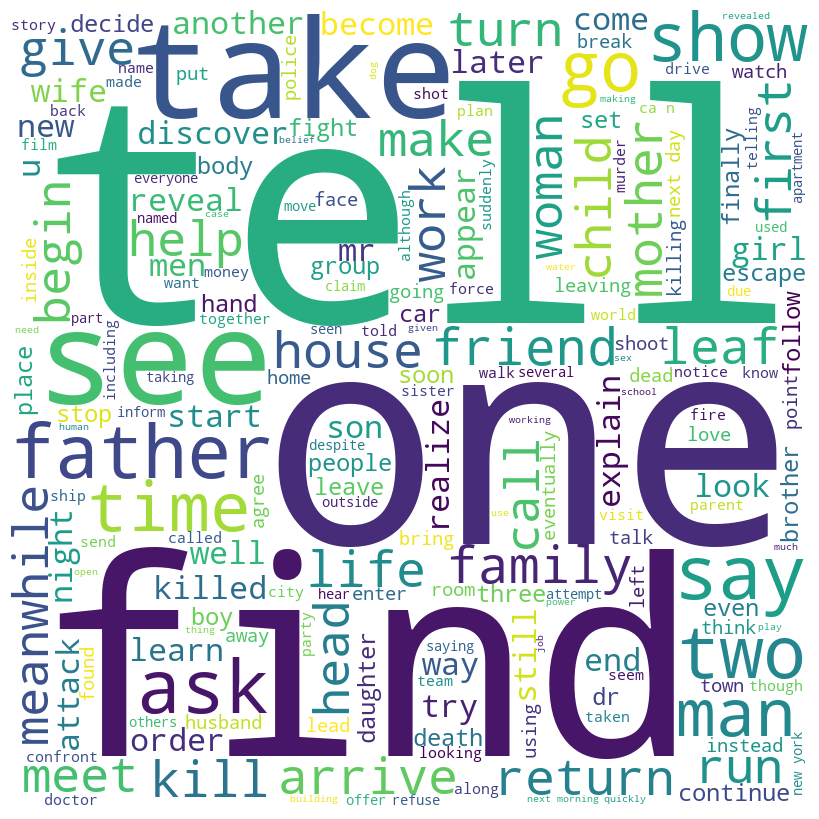

In [113]:
from wordcloud import WordCloud

# Concatenate the `overviews` into a single string
text = ' '.join(mpst_cleaned_df['overview'])

# Create a wordcloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)

# Plot the wordcloud
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Words, such as **tell**, **one**, and **find**, seem to be very important in this dataset. Many family-related words (e.g., **family**, **father**, **mother**) are seen. Verbs are also frequent words (e.g., **take**, **say**, **see**, **find**). Contextully speaking, **killed** can be important since it signals violent or action-packed scenes in which characters are killed. Depending on the genre of the movie, such as horror or thriller, the repeated use of this word may indicate that the movie has a darker or more intense tone.

Now we have clean, preprocessed texts! Let's save it as a csv file for a future use.

In [117]:
# Export to a csv file
#mpst_cleaned_df.to_csv('mpst_cleaned.csv', index=False)

Before closing this notebook, let's split the `tags` column into a list of unique tags. By creating a list of unique tags, we can perform more in-depth analysis on the data, such as finding the most common tags across all movies, or identifying trends or patterns in the tags.

In [115]:
# Check the `tags` column
mpst_cleaned_df['tags'].head()

0            cult, horror, gothic, murder, atmospheric
1                                             violence
2                                             romantic
3               inspiring, romantic, stupid, feel-good
4    cruelty, murder, dramatic, cult, violence, atm...
Name: tags, dtype: object

The number of tags associated with movies varies, with some movies being associated with multiple tags while others are associated with only one tag. To create a list of unique tags, we first need to split the column into a list of individual tags. Then we can concatenates all the tags in a list while removeing any leading/trailing white space at the same time.

In [116]:
# Split the 'tags' column into a list of individual tags
all_tags = []

for tag in mpst_cleaned_df['tags']:
    all_tags.append(re.split(',', tag))
    
mpst_cleaned_df['tags'] = all_tags

print(all_tags)

[['cult', ' horror', ' gothic', ' murder', ' atmospheric'], ['violence'], ['romantic'], ['inspiring', ' romantic', ' stupid', ' feel-good'], ['cruelty', ' murder', ' dramatic', ' cult', ' violence', ' atmospheric', ' action', ' romantic', ' revenge', ' sadist'], ['romantic', ' queer', ' flashback'], ['gothic', ' cruelty', ' violence', ' cult', ' revenge', ' sadist'], ['mystery', ' suspenseful', ' action', ' murder', ' flashback'], ['violence'], ['revenge', ' neo noir', ' murder', ' violence', ' flashback'], ['cult', ' prank'], ['cult', ' psychedelic', ' murder', ' violence'], ['tragedy', ' dramatic', ' murder'], ['murder'], ['flashback', ' autobiographical', ' home movie'], ['good versus evil'], ['suspenseful', ' depressing', ' realism'], ['boring', ' murder', ' cult', ' violence', ' atmospheric', ' haunting', ' romantic', ' sentimental'], ['flashback'], ['paranormal', ' horror', ' haunting'], ['suspenseful', ' neo noir', ' murder', ' violence', ' action', ' revenge'], ['romantic', ' h

In [118]:
# Concatenate all the tags into a single list and remove leading/trailing white space
tag_list = sum(all_tags, [])

for i in range(0, len(tag_list)):
    tag_list[i] = tag_list[i].strip()

# Create a sorted list of unique tags
tag_list = sorted(list(set(tag_list)))

# Print the list of unique tags and the number of unique tags
print(tag_list)
print(f"The number of unique tags is {len(tag_list)}.")

['absurd', 'action', 'adult comedy', 'allegory', 'alternate history', 'alternate reality', 'anti war', 'atmospheric', 'autobiographical', 'avant garde', 'blaxploitation', 'bleak', 'boring', 'brainwashing', 'christian film', 'claustrophobic', 'clever', 'comedy', 'comic', 'cruelty', 'cult', 'cute', 'dark', 'depressing', 'dramatic', 'entertaining', 'fantasy', 'feel-good', 'flashback', 'good versus evil', 'gothic', 'grindhouse film', 'haunting', 'historical', 'historical fiction', 'home movie', 'horror', 'humor', 'insanity', 'inspiring', 'intrigue', 'magical realism', 'melodrama', 'murder', 'mystery', 'neo noir', 'non fiction', 'paranormal', 'philosophical', 'plot twist', 'pornographic', 'prank', 'psychedelic', 'psychological', 'queer', 'realism', 'revenge', 'romantic', 'sadist', 'satire', 'sci-fi', 'sentimental', 'storytelling', 'stupid', 'suicidal', 'suspenseful', 'thought-provoking', 'tragedy', 'violence', 'western', 'whimsical']
The number of unique tags is 71.


We have created a list of unique tags (total 71).

## Summary

In this notebook, we have successfully cleaned and preprocessed our dataset, consisting of over 14,000 movie synopses, using various tools such as `WordNetLemmatizer`. This has prepared our data for feature engineering and modeling. Furthermore, we have created a list of unique tags for later use and generated a word cloud to quickly grasp the key themes and patterns in our dataset.

We also employed web scraping to obtain English titles for movies with non-English titles from the IMDb website. Although the web scraping process was not perfect, as some English titles failed to be scraped, it served as a valuable learning experience and demonstrated the importance of this technique for future projects.

With our dataset prepared, we are now ready to proceed with feature engineering and modeling in our next notebook, [**Supplementary_Part_2_Feature_Engineering_Modeling**](https://github.com/treelunar/2023_Capstone_BSTN/blob/main/Supplementary/Supplementary_Part_2_Feature_Engineering_Modeling.ipynb) in the **Supplementary** folder.

As a **reminder**, all notebooks in the Appendix folder, including this one, are sumpplementary to the main notebooks. Readers interested in the capstone project should primarily follow the main notebooks and refer to the supplementary notebooks if they wish to explore further.

With this solid foundation, we look forward to diving deeper into feature engineering and modeling in the next stage of our project.

## Acknowledgement

- [Problem HTTP error 403 in Python 3 Web Scraping](https://stackoverflow.com/questions/16627227/problem-http-error-403-in-python-3-web-scraping) was helpful in resolving the HTTP 403 reponse.
- [Stemming vs. Lemmatization in NLP](https://towardsdatascience.com/stemming-vs-lemmatization-in-nlp-dea008600a0) by Niklas Lang helped me understand the pros and cons of using each of the techniques and opting to lemmatization rather than stemming dealing with the current dataset.